In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np

# torch.manual_seed(1)
torch.cuda.set_device(0)

EPOCH = 10
LR = 0.001
DOWNLOAD_MNIST = True

train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=torchvision.transforms.ToTensor(),
                                        download=DOWNLOAD_MNIST, )
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
print(train_data.train_data.shape)

train_x = torch.unsqueeze(train_data.train_data, dim=1).type(torch.FloatTensor) / 255.
train_y = train_data.train_labels
print(train_x.shape)

test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000] / 255.  # Tensor on GPU
test_y = test_data.test_labels[:2000]

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


/home/browallia/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/browallia/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/browallia/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/browa

In [4]:
def train_mnist(model, batch_size, epochs, LR, weight_decay=None, lr_schedular=None):
    """train pipeline
    """
    if weight_decay is not None:
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    if lr_schedular is not None:
        schedular = torch.optim.lr_scheduler.StepLR(optimizer, epochs//3, 0.1)

    data_size = 20000
    loss_func = nn.CrossEntropyLoss()
    print(f'-----model: {model.get_name()}, batch_size: {batch_size}, epochs: {epochs}, LR: {LR}, weight_decay: {weight_decay}, lr_schedular: {lr_schedular}-----')
    for epoch in range(epochs):
        random_indx = np.random.permutation(data_size)
        for batch_i in range(data_size // batch_size):
            indx = random_indx[batch_i * batch_size:(batch_i + 1) * batch_size]

            b_x = train_x[indx, :].cuda()
            b_y = train_y[indx].cuda()
    #         print(b_x.shape)
    #         print(b_y.shape)

            output = model(b_x)
            loss = loss_func(output, b_y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch_i % int((data_size // batch_size)/3) == 0:
                test_output = model(test_x.cuda()).cpu()
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                # pred_y = torch.max(test_output, 1)[1].data.squeeze()
                accuracy = torch.sum(pred_y == test_y).type(torch.FloatTensor) / test_y.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.3f' % accuracy)
        if lr_schedular is not None:
            schedular.step()

    model.cpu()
    test_output = model(test_x[:10])
    pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

    print(pred_y, 'prediction number')
    print(test_y[:10], 'real number')
    


In [14]:
class FC(nn.Module):
    def __init__(self, dropout=False):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.fc3 = nn.Linear(10, 10)
        self.dropout = dropout
        if self.dropout:
            self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        if self.dropout:
            x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)


        output = x
        return output
    
    def get_name(self):
        return self.__class__.__name__

class BasicBlcok(nn.Module):
    def __init__(self, planes, residual=False):
        super(BasicBlcok, self).__init__()
        self.residual = residual
        self.conv1 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        if self.residual:
            self.res = nn.Sequential(
                            nn.Conv2d(planes, planes, kernel_size=1, stride=2, padding=0, bias=False),
                            nn.BatchNorm2d(planes)
                        )

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.residual:
            res = self.res(res)
            x += res
        x = self.relu2(x)


        return x
class CNN(nn.Module):
    def __init__(self, in_planes, planes, residual=False):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.layer1 = BasicBlcok(planes, residual)
        self.layer2 = BasicBlcok(planes, residual)
        self.pooling = nn.AvgPool2d(7)
        self.linear = nn.Linear(16, 10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
    def get_name(self):
        return self.__class__.__name__



In [18]:
# experiment
fc = FC().cuda()
train_mnist(model=fc, batch_size=50, epochs=10, LR=0.001)
fc_1 = FC(dropout=True).cuda()
train_mnist(model=fc_1, batch_size=50, epochs=10, LR=0.001)
cnn = CNN(1, 16).cuda()
train_mnist(model=cnn, batch_size=50, epochs=10, LR=0.001)

-----model: FC, batch_size: 50, epochs: 10, LR: 0.001, weight_decay: None, lr_schedular: None-----
Epoch:  0 | train loss: 2.3371 | test accuracy: 0.147
Epoch:  0 | train loss: 0.3800 | test accuracy: 0.833
Epoch:  0 | train loss: 0.3469 | test accuracy: 0.882
Epoch:  0 | train loss: 0.3624 | test accuracy: 0.893
Epoch:  1 | train loss: 0.1704 | test accuracy: 0.892
Epoch:  1 | train loss: 0.3743 | test accuracy: 0.908
Epoch:  1 | train loss: 0.3379 | test accuracy: 0.917
Epoch:  1 | train loss: 0.0912 | test accuracy: 0.921
Epoch:  2 | train loss: 0.2151 | test accuracy: 0.920
Epoch:  2 | train loss: 0.1553 | test accuracy: 0.914
Epoch:  2 | train loss: 0.1415 | test accuracy: 0.931
Epoch:  2 | train loss: 0.2040 | test accuracy: 0.932
Epoch:  3 | train loss: 0.1391 | test accuracy: 0.932
Epoch:  3 | train loss: 0.1761 | test accuracy: 0.938
Epoch:  3 | train loss: 0.1428 | test accuracy: 0.939
Epoch:  3 | train loss: 0.0934 | test accuracy: 0.941
Epoch:  4 | train loss: 0.0294 | test

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 2.00 GiB total capacity; 1008.72 MiB already allocated; 0 bytes free; 1.02 GiB reserved in total by PyTorch)

In [7]:
test_output = fc(test_x[:1])
pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU

print(pred_y, 'prediction number')
print(test_y[:1], 'real number')

tensor(7) prediction number
tensor([7]) real number


In [8]:
test_output

tensor([[ 2.3913, -6.0182,  4.3395,  4.6365, -6.4984, -2.3497, -5.2593, 11.5579,
          0.0529,  4.0067]], grad_fn=<AddmmBackward>)

In [9]:
test_x[:1].shape

torch.Size([1, 1, 28, 28])

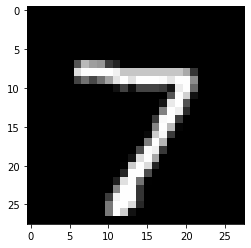

In [10]:
plt.imshow(test_x[:1].numpy().squeeze(), 'gray')